In [ ]:
!pip install timm
!pip install torchvision
!pip install wandb
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
from tqdm import tqdm
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_SAMPLES = 12
RUN_NAME = 'baseline'
SEED = 0
BATCH_SIZE = 128
GEN_LEARNING_RATE = 0.0005
DISC_LEARNING_RATE = 0.00005
BETA1 = 0.5
BETA2 = 0.999
LATENT_DIMS = 100
NUM_GEN_KERN = 128
NUM_DISC_KERN = 128
NUM_CHANNELS = 1
EPOCHS = 20

In [ ]:
def prepare_data(BATCH_SIZE):

    num_cores = os.cpu_count()

    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])
    train_set = torchvision.datasets.MNIST(
        'content/train',
        train=True,
        download = True,
        transform=transformation
    )

    dataset_size = len(train_set)
    trimmed_dataset_size = dataset_size - (dataset_size % BATCH_SIZE)
    train_set.data = train_set.data[:trimmed_dataset_size]
    train_set.targets = train_set.targets[:trimmed_dataset_size]

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_cores
        )

    return train_loader


def initialize_weights(mod):
    if isinstance(mod, nn.Conv2d) or isinstance(mod, nn.ConvTranspose2d):
        nn.init.normal_(mod.weight, 0.0, 0.02)
    elif isinstance(mod, nn.BatchNorm2d):
        nn.init.normal_(mod.weight, 1.0, 0.02)
        nn.init.constant_(mod.bias, 0)


def reset_gradients(network):
    for param in network.parameters():
        param.grad = None


def model_setup(device=DEVICE):
    generator = Generator()
    generator.apply(initialize_weights)
    generator.to(device)

    discriminator = Discriminator()
    discriminator.apply(initialize_weights)
    discriminator.to(device)

    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=GEN_LEARNING_RATE, betas=(BETA1, BETA2))
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=DISC_LEARNING_RATE, betas=(BETA1, BETA2))

    calc_loss = nn.BCELoss()

    return generator, discriminator, gen_optimizer, disc_optimizer, calc_loss

def train_setup(images, discriminator):

    actual_images = images.to(DEVICE)
    real_batch_size = discriminator(actual_images).view(-1).size(0)
    real_label = torch.ones((real_batch_size, ), dtype=torch.float32, device=DEVICE)
    fake_label = torch.zeros((real_batch_size, ), dtype=torch.float32, device=DEVICE)

    return actual_images, real_batch_size, real_label, fake_label

In [ ]:
class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()

    self.network = nn.Sequential(
        nn.ConvTranspose2d(
            in_channels=LATENT_DIMS,
            out_channels=NUM_GEN_KERN * 4  ,
            kernel_size=4,
            stride=2,
            padding=0,
            bias=False
            ),
        nn.BatchNorm2d(NUM_GEN_KERN * 4),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=NUM_GEN_KERN * 4,
            out_channels=NUM_GEN_KERN * 2,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.BatchNorm2d(NUM_GEN_KERN * 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=NUM_GEN_KERN * 2,
            out_channels=NUM_GEN_KERN,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.BatchNorm2d(NUM_GEN_KERN),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=NUM_GEN_KERN,
            out_channels=NUM_CHANNELS,
            kernel_size=4,
            stride=2,
            padding=3,
            bias=False
            ),
        nn.Tanh(),
    )

  def forward(self, input):
    return self.network(input)



class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.network = nn.Sequential(
        nn.Conv2d(
            in_channels=NUM_CHANNELS,
            out_channels=NUM_DISC_KERN,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(
            in_channels=NUM_DISC_KERN,
            out_channels=NUM_DISC_KERN * 2,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.BatchNorm2d(NUM_DISC_KERN * 2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(
            in_channels=NUM_DISC_KERN * 2,
            out_channels=NUM_DISC_KERN * 4,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.BatchNorm2d(NUM_DISC_KERN * 4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(
            in_channels=NUM_DISC_KERN * 4,
            out_channels=NUM_CHANNELS,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.Sigmoid()
        )

  def forward(self, input):
    return self.network(input)

In [ ]:
def run():

    wandb.init(
        project='BASELINE-DCGAN',
        config={
        'num_samples': NUM_SAMPLES,
        'run_name': RUN_NAME,
        'seed': SEED,
        'batch_size': BATCH_SIZE,
        'gen_learning_rate': GEN_LEARNING_RATE,
        'disc_learning_rate': DISC_LEARNING_RATE,
        'beta1': BETA1,
        'beta2': BETA2,
        'latent_dims': LATENT_DIMS,
        'num_gen_kern': NUM_GEN_KERN,
        'num_disc_kern': NUM_DISC_KERN,
        'num_channels': NUM_CHANNELS,
        'epochs': EPOCHS
    })

    config = wandb.config

    if not os.path.exists('/content/logs'):
      os.mkdir('/content/logs')
    if not os.path.exists(f'/content/logs/{config.run_name}'):
      os.mkdir(f'/content/logs/{config.run_name}')

    manual_seed = config.seed
    random.seed(manual_seed)
    torch.manual_seed(manual_seed)

    if torch.cuda.is_available():
      torch.cuda.manual_seed(manual_seed)
      torch.cuda.manual_seed_all(manual_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    train_loader = prepare_data(config.batch_size)

    generator, discriminator, gen_optimizer, disc_optimizer, calc_loss = model_setup()

    gen_losses = []
    disc_losses = []
    real_confs = []
    fake_confs = []
    generated_confs = []

    discriminator.train()
    generator.train()

    for epoch in range(1, config.epochs + 1):

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
            actual_images, real_batch_size, real_label, fake_label = train_setup(images, discriminator)

            # 1: train discrim
            reset_gradients(discriminator)

            out = discriminator(actual_images).view(-1)
            real_loss = calc_loss(out, real_label)
            real_loss.backward()
            real_conf = real_loss.mean().item()


            # 2: full pass on generated images
            noise = torch.randn(config.batch_size, config.latent_dims, 1, 1, device=DEVICE)

            fake_images = generator(noise)
            out = discriminator(fake_images.detach()).view(-1)
            fake_loss = calc_loss(out, fake_label)
            fake_loss.backward()
            fake_conf = fake_loss.mean().item()
            discriminator_loss = real_loss + fake_loss
            disc_optimizer.step()

            # 3: train generator
            reset_gradients(generator)

            out = discriminator(fake_images).view(-1)
            generator_loss = calc_loss(out, real_label)
            generator_loss.backward()
            generated_conf = generator_loss.mean().item()

            gen_optimizer.step()

            s_metrics = {
                'discriminator_loss': discriminator_loss.item(),
                'generator_loss': generator_loss.item(),
                'real_conf': real_conf,
                'fake_conf': fake_conf,
                'generated_conf': generated_conf
            }

            gen_losses.append(generator_loss.item())
            disc_losses.append(discriminator_loss.item())
            real_confs.append(real_conf)
            fake_confs.append(fake_conf)
            generated_confs.append(generated_conf)

        discriminator_loss = sum(disc_losses) / len(disc_losses)
        generator_loss = sum(gen_losses) / len(gen_losses)
        real_conf = sum(real_confs) / len(real_confs)
        fake_conf = sum(fake_confs) / len(fake_confs)
        generated_conf = sum(generated_confs) / len(generated_confs)

        e_metrics = {
            'discriminator_loss': discriminator_loss,
            'generator_loss': generator_loss,
            'real_conf': real_conf,
            'fake_conf': fake_conf,
            'generated_conf': generated_conf,
        }
        wandb.log({**s_metrics, **e_metrics})
        print(f'Epoch ', epoch, '/', config.epochs, ': Discriminator Loss: ', sum(disc_losses) / len(disc_losses), 'Generator: ', sum(gen_losses) / len(gen_losses))

        samples = []
        static_noise = torch.randn(real_batch_size, config.latent_dims, 1, 1, device=DEVICE)
        generator.eval()
        samples = generator(static_noise)

        grid = vutils.make_grid(samples[:24], normalize=True, scale_each=True)
        grid = grid.permute(1, 2, 0).cpu().numpy()
        grid = (grid * 255).astype(np.uint8)
        wandb.log({'samples': wandb.Image(grid)})

        if epoch % 5 == 0 or epoch == 1:
            plt.figure(figsize=(10, 10))
            for x in range(25):
                sample = samples[x]
                sample = np.reshape(sample.cpu().detach().numpy(), (28, 28))
                plt.subplot(5, 5, x + 1)
                plt.imshow(sample, cmap='gray')
                plt.axis('off')
            plt.show()
        generator.train()

        torch.save(generator.state_dict(), f'/content/logs/{config.run_name}/generator_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'/content/logs/{config.run_name}/discriminator_{epoch}.pth')

        torch.cuda.empty_cache()
    wandb.finish()
    return generator, discriminator

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 59965861.86it/s]


Extracting content/train/MNIST/raw/train-images-idx3-ubyte.gz to content/train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1696649.63it/s]


Extracting content/train/MNIST/raw/train-labels-idx1-ubyte.gz to content/train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13878943.44it/s]


Extracting content/train/MNIST/raw/t10k-images-idx3-ubyte.gz to content/train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3707771.27it/s]


Extracting content/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to content/train/MNIST/raw



  0%|          | 0/468 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
100%|██████████| 468/468 [00:57<00:00,  8.13it/s]


Epoch  1 / 20 : Discriminator Loss:  1.0876860487410145 Generator:  1.6039681031535833


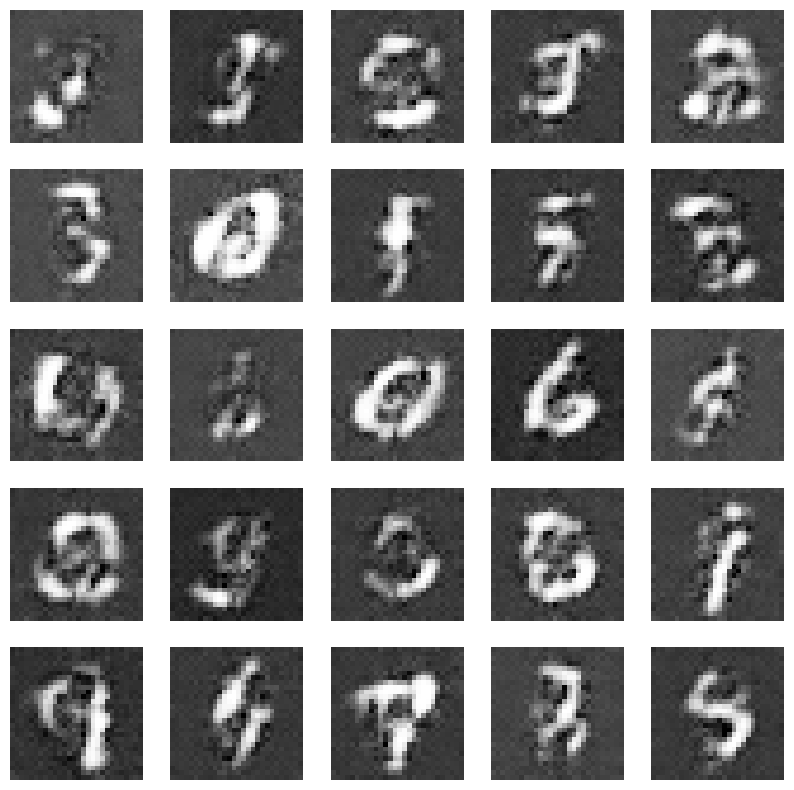

100%|██████████| 468/468 [01:01<00:00,  7.59it/s]


Epoch  2 / 20 : Discriminator Loss:  0.7985756411893755 Generator:  1.780200944146794


100%|██████████| 468/468 [01:01<00:00,  7.61it/s]


Epoch  3 / 20 : Discriminator Loss:  0.592629876523743 Generator:  2.1955004740198625


100%|██████████| 468/468 [01:01<00:00,  7.58it/s]


Epoch  4 / 20 : Discriminator Loss:  0.4560290506969278 Generator:  2.7072934424186235


100%|██████████| 468/468 [01:01<00:00,  7.60it/s]


Epoch  5 / 20 : Discriminator Loss:  0.36858166825328753 Generator:  3.2065229415829872


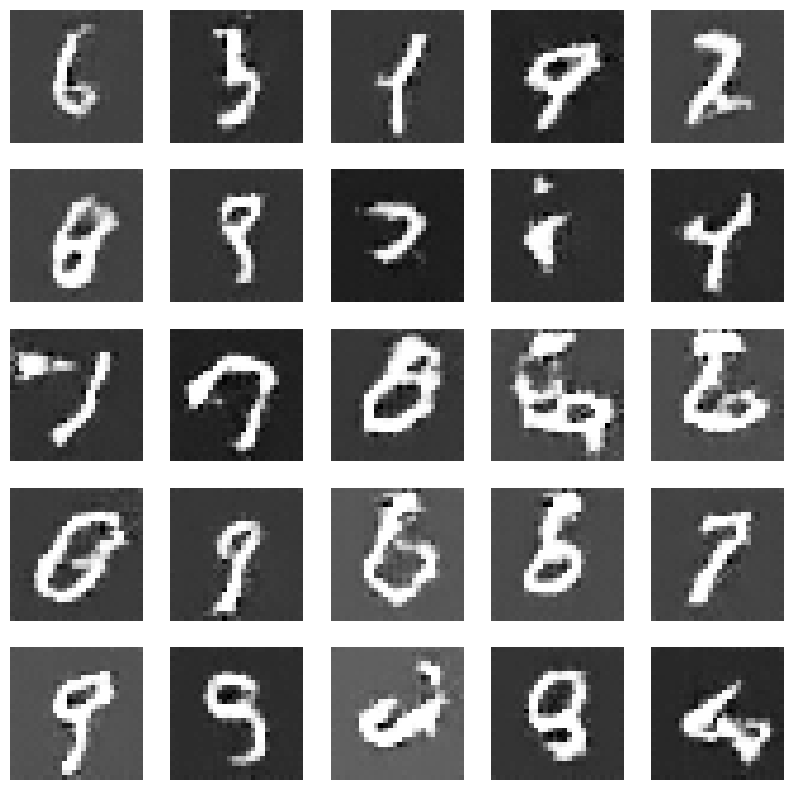

100%|██████████| 468/468 [01:01<00:00,  7.59it/s]


Epoch  6 / 20 : Discriminator Loss:  0.3085773186570768 Generator:  3.6779109124051796


100%|██████████| 468/468 [01:01<00:00,  7.62it/s]


Epoch  7 / 20 : Discriminator Loss:  0.2652299769504322 Generator:  4.1000284432446055


100%|██████████| 468/468 [01:01<00:00,  7.62it/s]


Epoch  8 / 20 : Discriminator Loss:  0.23245232502387467 Generator:  4.486645531828683


100%|██████████| 468/468 [01:01<00:00,  7.60it/s]


Epoch  9 / 20 : Discriminator Loss:  0.20717129202439138 Generator:  4.75820008234067


100%|██████████| 468/468 [01:01<00:00,  7.61it/s]


Epoch  10 / 20 : Discriminator Loss:  0.18682302773796888 Generator:  4.985210759616178


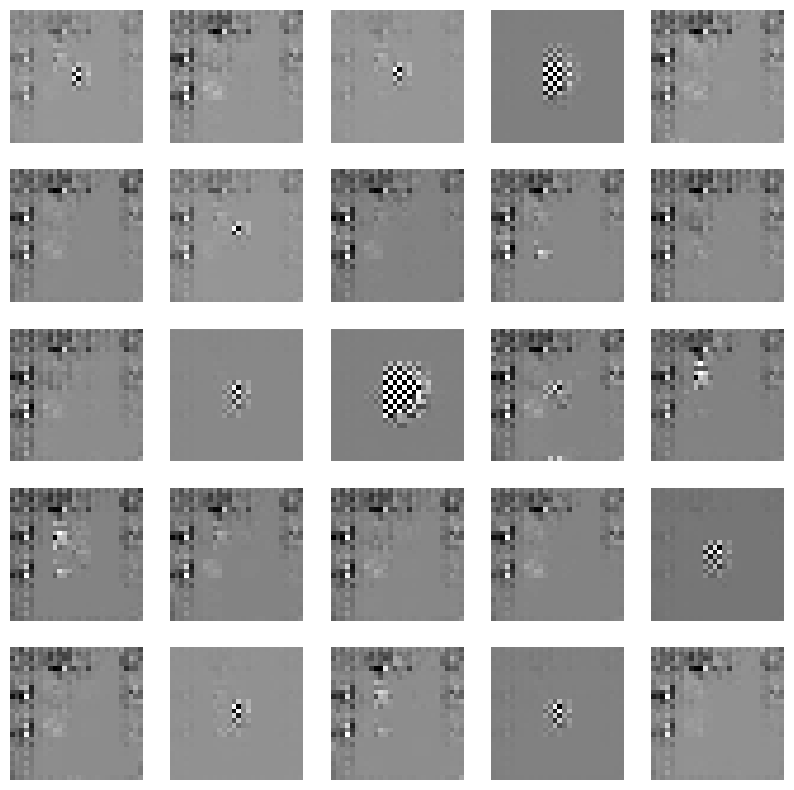

100%|██████████| 468/468 [01:01<00:00,  7.62it/s]


Epoch  11 / 20 : Discriminator Loss:  0.16994929405326417 Generator:  5.233746251301216


100%|██████████| 468/468 [01:01<00:00,  7.60it/s]


Epoch  12 / 20 : Discriminator Loss:  0.1558158794786569 Generator:  5.5476766329688525


100%|██████████| 468/468 [01:01<00:00,  7.59it/s]


Epoch  13 / 20 : Discriminator Loss:  0.18125030167288497 Generator:  5.802627101314011


100%|██████████| 468/468 [01:01<00:00,  7.59it/s]


Epoch  14 / 20 : Discriminator Loss:  0.18032969421995096 Generator:  5.67829439072541


100%|██████████| 468/468 [01:01<00:00,  7.60it/s]


Epoch  15 / 20 : Discriminator Loss:  0.1690844323222535 Generator:  5.683752170955481


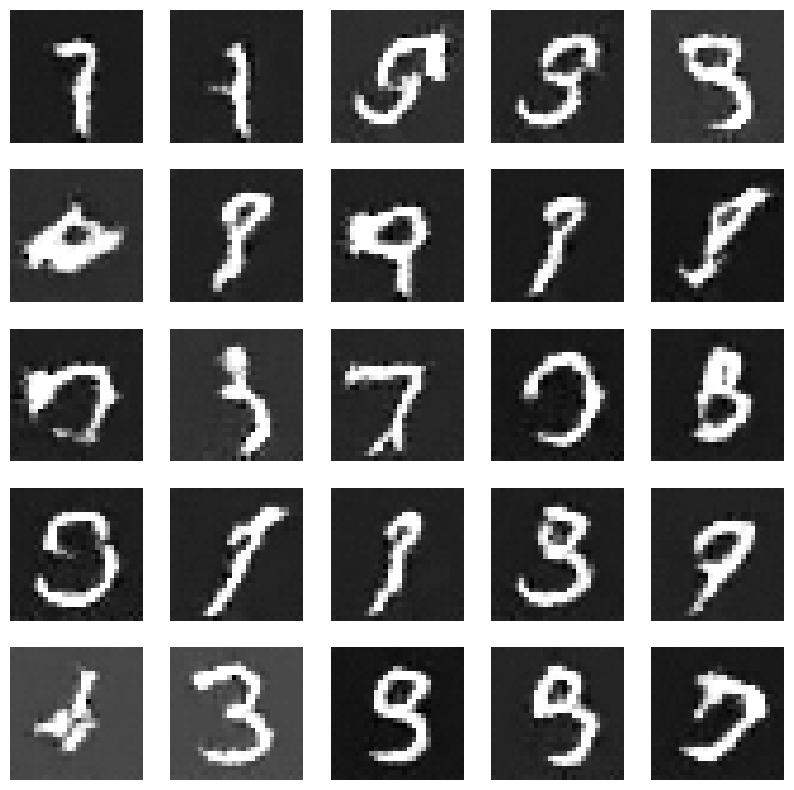

100%|██████████| 468/468 [01:01<00:00,  7.60it/s]


Epoch  16 / 20 : Discriminator Loss:  0.15879841857765914 Generator:  5.754199963631148


100%|██████████| 468/468 [01:01<00:00,  7.59it/s]


Epoch  17 / 20 : Discriminator Loss:  0.14959951452136744 Generator:  5.857991007203962


100%|██████████| 468/468 [01:01<00:00,  7.59it/s]


Epoch  18 / 20 : Discriminator Loss:  0.14136371705328593 Generator:  5.980015238319813


100%|██████████| 468/468 [01:01<00:00,  7.61it/s]


Epoch  19 / 20 : Discriminator Loss:  0.13396993700350104 Generator:  6.118372840996207


100%|██████████| 468/468 [01:01<00:00,  7.61it/s]


Epoch  20 / 20 : Discriminator Loss:  0.12730851413151742 Generator:  6.256581679135402


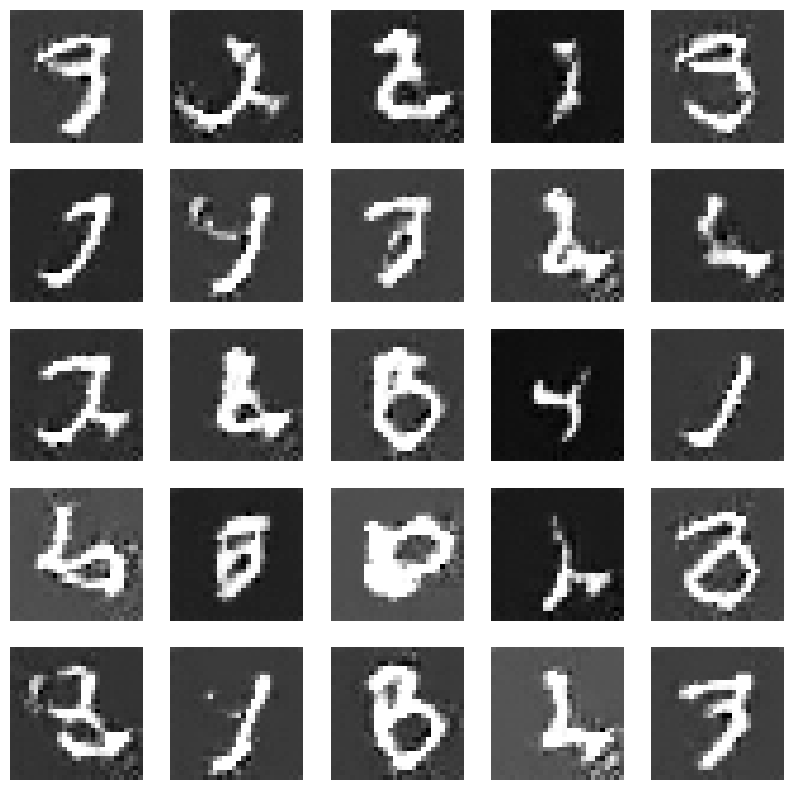

discriminator_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
fake_conf,█▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
generated_conf,▁▁▂▃▃▄▅▅▆▆▆▇▇▇▇▇▇███
generator_loss,▁▁▂▃▃▄▅▅▆▆▆▇▇▇▇▇▇███
real_conf,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
discriminator_loss,0.12731
fake_conf,0.07387
generated_conf,6.25658
generator_loss,6.25658
real_conf,0.05344


In [ ]:
gen, disc = run()